In [27]:
from pathlib import Path
import re
import itertools
import json
from tqdm.auto import tqdm
import oimdp
import torch
from torch.nn.functional import cosine_similarity
from transformers import AutoModelForTextEncoding, AutoTokenizer
from utils import get_keywords, contains_arabic
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def batched(iterable, n):
    # batched('ABCDEFG', 3) → ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    iterator = iter(iterable)
    while batch := tuple(itertools.islice(iterator, n)):
        yield batch

In [3]:
model_id = "CAMeL-Lab/bert-base-arabic-camelbert-ca"
m = AutoModelForTextEncoding.from_pretrained(model_id)
tok = AutoTokenizer.from_pretrained(model_id)
m.to("cuda");

/home/gpucce/Repos/arabo_panzeca/conda_venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
kwds = get_keywords()
with torch.inference_mode():
    for kwd in tqdm(kwds):
        kwd["emb"] = m(**tok(kwd["sentence"], return_tensors="pt").to("cuda"))["last_hidden_state"][0, 1]

100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


In [5]:
d = Path("./all_data/0025AH/data")
all_d = d.glob("./**/*-ara1")
all_texts = {i.name: oimdp.parse(i.read_text()) for i in all_d}

In [7]:
with torch.inference_mode():
    all_scores = {kwd["keyword"]:{} for kwd in kwds}
    all_clean_texts = {}
    for name, i in tqdm(all_texts.items(), total=len(all_texts)):
        all_clean_texts[name] = []
        for j in i.content:
            if not isinstance(j, oimdp.structures.Paragraph):
                all_clean_texts[name].append([])
                for h in str(j).split():
                    if contains_arabic(h):
                        all_clean_texts[name][-1].append(h)
        for batch in batched(all_clean_texts[name], 16):
            batch = [" ".join(i) for i in batch]
            _batch = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=256).to("cuda")
            hidden_states = m(**_batch).last_hidden_state
            for kwd in kwds:
                keyword = kwd["keyword"]
                sims = cosine_similarity(
                    hidden_states.reshape(-1, hidden_states.shape[-1]),
                    kwd["emb"], dim=-1).cpu().numpy()

                for i, j in zip(_batch.input_ids.reshape(-1), sims):
                    j = j.item()

                    if i in [0, 1, 2, 3]:
                        continue
                    i = tok.convert_ids_to_tokens(i.cpu().tolist())
                    if i in all_scores[keyword]:
                        all_scores[keyword][i].append(j)
                    else:
                        all_scores[keyword][i] = [j]

for k, w in all_scores.items():
    for i, j in w.items():
        w[i] = sum(j) / len(j)


100%|██████████| 61/61 [02:11<00:00,  2.16s/it]


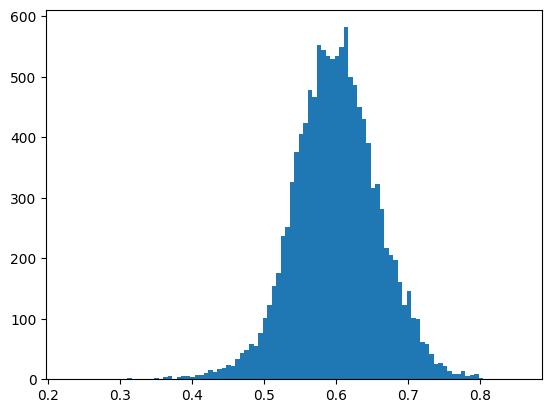

In [125]:
plt.hist(all_scores[list(all_scores.keys())[0]].values(), bins=100);

In [25]:
with open("all_scores.json", "w") as f:
    json.dump(all_scores, f)

In [47]:
df = pd.DataFrame.from_dict(all_scores).sort_values(list(all_scores.keys())[0], ascending=False).reset_index()
df = df.loc[~df.loc[:, "index"].str.contains("##"), :]

array([[<Axes: title={'center': 'خالق'}>,
        <Axes: title={'center': 'صانع'}>]], dtype=object)

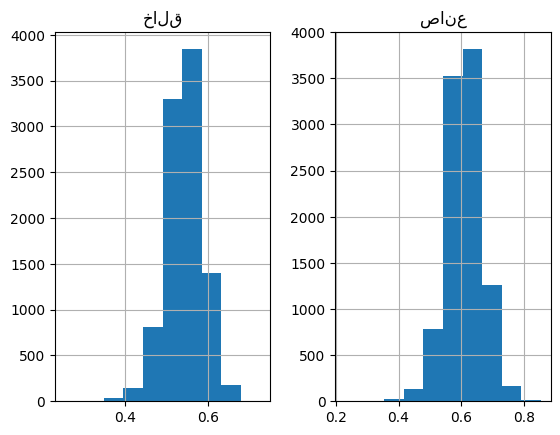

In [49]:
df.hist()

In [46]:
df.shape

(9726, 3)

In [20]:
from transformers import pipeline

src_text = ["اتبع قلبك فحسب.", "وين راهي دّوش؟"]

model_name = "inceptionai/jais-13b-chat"
pipe = pipeline("text-generation", model=model_name, device="cuda")

print(pipe("translate the following text in English: وين راهي دّوش؟"))


A new version of the following files was downloaded from https://huggingface.co/inceptionai/jais-13b-chat:
- configuration_jais.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/inceptionai/jais-13b-chat:
- configuration_jais.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/inceptionai/jais-13b-chat:
- modeling_jais.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


KeyboardInterrupt: 

In [11]:
translated

tensor([[61108, 15540, 15540,  ..., 15540, 15540, 25894],
        [61108, 17181, 17181,  ..., 17181, 17181, 25894]], device='cuda:0')